In [1]:
# Remember to adjust your student ID in meta.xml
import numpy as np
import pickle
import random
import gym
from simple_custom_taxi_env import SimpleTaxiEnv
from tqdm import tqdm
import globals

c:\Users\qwer9\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
def find_nearest_station(taxi_pos, station):
    distance = np.inf
    for (x,y) in station:
        temp_distance = abs(taxi_pos[0] - x) + abs(taxi_pos[1] - y)
        if temp_distance < distance:
            distance = temp_distance
            goal = (x, y)
    return goal

In [ ]:
def table_q_learning(
    episode=5000, alpha=0.1, gamma=0.99,
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, memory=10000
):
    q_table = {}
    total_rewards = []
    total_steps = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment
        fuel_limit = 1 if i < 0.1 * episode else 1000
        env = SimpleTaxiEnv(fuel_limit=fuel_limit)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        saved = False
        if (i + 1) % memory == 0:
            saved = True
            print(f"=========================={i+1}th episodes Start!==========================")

        # Unpack environment state
        (
            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        ) = raw_state

        # Setup global variables
        station = [(R_x, R_y), (G_x, G_y), (Y_x, Y_y), (B_x, B_y)]
        globals.possible_passenger = set(station)
        globals.possible_destination = set(station)
        globals.has_passenger = False

        taxi_pos = (taxi_row, taxi_col)
        goal = find_nearest_station(taxi_pos, list(station))
        globals.goal = goal

        relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
        state = (
            obstacle_south, obstacle_north, obstacle_east, obstacle_west,
            relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
        )

        # Q-learning loop
        while not done:
            # Initialize Q-values for unseen state
            if state not in q_table:
                q_table[state] = np.zeros(6)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])

            # Take action in environment
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward

            step_count += 1

            if saved:
                env.render_env(taxi_pos, action = action, step = step_count)

            # Unpack next state
            (
                taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
                obstacle_north, obstacle_south, obstacle_east, obstacle_west,
                passenger_look, destination_look
            ) = next_raw_state

            taxi_pos = (taxi_row, taxi_col)

            # Update adjacent observations
            adjacent = {
                (taxi_row + 1, taxi_col), (taxi_row - 1, taxi_col),
                (taxi_row, taxi_col + 1), (taxi_row, taxi_col - 1),
                (taxi_row, taxi_col)
            }

            if passenger_look:
                globals.possible_passenger.intersection_update(adjacent)
            else:
                globals.possible_passenger.difference_update(adjacent)

            if destination_look:
                globals.possible_destination.intersection_update(adjacent)
            else:
                globals.possible_destination.difference_update(adjacent)

            # Goal logic
            if not globals.has_passenger:
                if len(globals.possible_passenger) == 1:
                    if taxi_pos in globals.possible_passenger and action == 4:
                        globals.has_passenger = True
                        globals.possible_passenger = set()
                        goal = list(globals.possible_destination)[0]
                        globals.goal = goal
                        shaped_reward += 20
                    else:
                        goal = list(globals.possible_passenger)[0]
                        globals.goal = goal
                else:
                    if globals.goal in globals.possible_passenger:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_passenger))
                        globals.goal = goal
            else:
                if action == 5:
                    if len(globals.possible_destination) == 1 and taxi_pos in globals.possible_destination:
                        shaped_reward += 100
                    else:
                        globals.has_passenger = False
                        globals.possible_passenger = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                        shaped_reward -= 30
                        if saved:
                            print("Passenger Dropped in a wrong place")
                else:
                    if globals.goal in globals.possible_destination:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_destination))
                        globals.goal = goal

            # Compute next state
            relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
            next_state = (
                obstacle_south, obstacle_north, obstacle_east, obstacle_west,
                relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
            )

            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward shaping (distance to goal)
            shaped_reward -= 1 * (abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]))
            total_reward += shaped_reward

            if saved:
                print(f"Shaped_Reward: {shaped_reward}, Reward: {reward}")

            # Q-learning update
            q_table[state][action] += alpha * (
                shaped_reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)

        # Optional progress logging
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return q_table, total_rewards


def save_q_table(q_table, filename='q_table.pkl'):
    """Save the Q-table to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

In [13]:
q_table, total_rewards = table_q_learning(episode = 1000000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.01, epsilon_decay = 0.9999, memory = 10000000)
save_q_table(q_table)

 10%|▉         | 99496/1000000 [00:05<00:50, 17679.28it/s]

Episode: 100000/1000000, Total Reward: -7.1, Steps: 1, Epsilon: 0.0100


 20%|██        | 200070/1000000 [05:31<38:33, 345.71it/s]  

Episode: 200000/1000000, Total Reward: 56.200000000000074, Steps: 28, Epsilon: 0.0100


 30%|███       | 300058/1000000 [10:05<36:07, 322.87it/s]  

Episode: 300000/1000000, Total Reward: 96.49999999999999, Steps: 25, Epsilon: 0.0100


 40%|████      | 400070/1000000 [14:22<18:06, 552.14it/s]  

Episode: 400000/1000000, Total Reward: -12356.000000000233, Steps: 1000, Epsilon: 0.0100


 50%|█████     | 500110/1000000 [17:36<14:20, 580.92it/s]

Episode: 500000/1000000, Total Reward: 129.39999999999998, Steps: 16, Epsilon: 0.0100


 60%|██████    | 600042/1000000 [21:37<19:21, 344.38it/s]  

Episode: 600000/1000000, Total Reward: -305.0000000000015, Steps: 480, Epsilon: 0.0100


 70%|███████   | 700071/1000000 [25:36<11:55, 419.32it/s]  

Episode: 700000/1000000, Total Reward: 160.20000000000002, Steps: 8, Epsilon: 0.0100


 80%|████████  | 800194/1000000 [28:54<04:25, 751.28it/s]

Episode: 800000/1000000, Total Reward: 88.6, Steps: 24, Epsilon: 0.0100


 90%|█████████ | 900101/1000000 [32:04<02:34, 647.51it/s]

Episode: 900000/1000000, Total Reward: 165.4, Steps: 6, Epsilon: 0.0100


100%|██████████| 1000000/1000000 [34:52<00:00, 477.98it/s]

Episode: 1000000/1000000, Total Reward: 75.80000000000001, Steps: 22, Epsilon: 0.0100


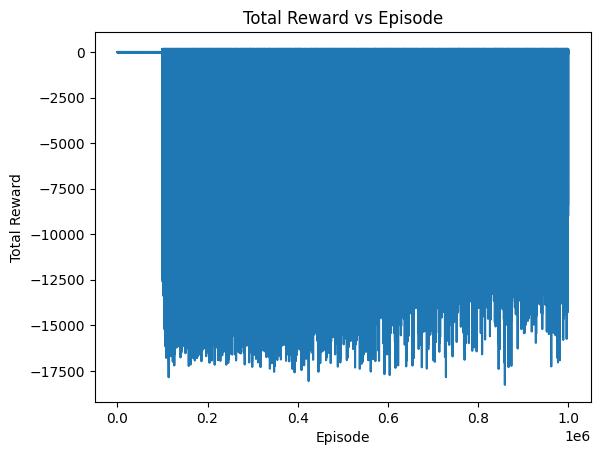

In [14]:
# plot the total reward
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()

In [4]:
def lazy_table_q_learning(episode=5000, alpha=0.1, gamma=0.99,
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, memory=10000, partial=0.5
):
    q_table = {}
    total_rewards = []
    total_steps = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment
        fuel_limit = 1 if i < partial*episode else 1000
        env = SimpleTaxiEnv(fuel_limit=fuel_limit)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        saved = False
        if (i + 1) % memory == 0:
            saved = True
            print(f"=========================={i+1}th episodes Start!==========================")

        # Unpack environment state
        (
            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        ) = raw_state

        # Setup global variables
        station = [(R_x, R_y), (G_x, G_y), (Y_x, Y_y), (B_x, B_y)]
        globals.possible_passenger = set(station)
        globals.possible_destination = set(station)
        globals.has_passenger = False

        taxi_pos = (taxi_row, taxi_col)
        goal = find_nearest_station(taxi_pos, list(station))
        globals.goal = goal

        relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
        state = (
            obstacle_south, obstacle_north, obstacle_east, obstacle_west,
            relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
        )

        # Q-learning loop
        while not done:
            # Initialize Q-values for unseen state
            if state not in q_table:
                q_table[state] = np.zeros(6)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])

            # Take action in environment
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward

            step_count += 1

            if saved:
                env.render_env(taxi_pos, action = action, step = step_count)

            # Unpack next state
            (
                taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
                obstacle_north, obstacle_south, obstacle_east, obstacle_west,
                passenger_look, destination_look
            ) = next_raw_state

            taxi_pos = (taxi_row, taxi_col)

            # Update adjacent observations
            adjacent = {
                (taxi_row + 1, taxi_col), (taxi_row - 1, taxi_col),
                (taxi_row, taxi_col + 1), (taxi_row, taxi_col - 1),
                (taxi_row, taxi_col)
            }

            if passenger_look:
                globals.possible_passenger.intersection_update(adjacent)
            else:
                globals.possible_passenger.difference_update(adjacent)

            if destination_look:
                globals.possible_destination.intersection_update(adjacent)
            else:
                globals.possible_destination.difference_update(adjacent)

            # Goal logic
            if not globals.has_passenger:
                if len(globals.possible_passenger) == 1:
                    if taxi_pos in globals.possible_passenger and action == 4:
                        globals.has_passenger = True
                        globals.possible_passenger = set()
                        goal = list(globals.possible_destination)[0]
                        globals.goal = goal
                        shaped_reward += 20
                    else:
                        goal = list(globals.possible_passenger)[0]
                        globals.goal = goal
                else:
                    if globals.goal in globals.possible_passenger:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_passenger))
                        globals.goal = goal
            else:
                if action == 5:
                    if len(globals.possible_destination) == 1 and taxi_pos in globals.possible_destination:
                        shaped_reward += 100
                    else:
                        globals.has_passenger = False
                        globals.possible_passenger = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                        shaped_reward -= 30
                        if saved:
                            print("Passenger Dropped in a wrong place")
                else:
                    if globals.goal in globals.possible_destination:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_destination))
                        globals.goal = goal

            # Compute next state
            relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
            next_state = (
                obstacle_south, obstacle_north, obstacle_east, obstacle_west,
                relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger
            )

            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward shaping (distance to goal)
            # shaped_reward -= 1 * (abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]))
            total_reward += reward

            if saved:
                print(f"Shaped_Reward: {reward}, Reward: {reward}")

            # Q-learning update
            q_table[state][action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)

        # Optional progress logging
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return q_table, total_rewards


def save_q_table(q_table, filename='lazy_q_table.pkl'):
    """Save the Q-table to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

In [5]:
lazy_q_table, lasy_reward = lazy_table_q_learning(episode = 100000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.001, epsilon_decay = 0.9999, memory = 100000, partial = 0.95)
save_q_table(lazy_q_table, filename='lazy_q_table.pkl')

 14%|█▎        | 13537/100000 [00:00<00:04, 18456.17it/s]

Episode: 10000/100000, Total Reward: -20.1, Steps: 1, Epsilon: 0.3679


 24%|██▍       | 24290/100000 [00:01<00:03, 20556.46it/s]

Episode: 20000/100000, Total Reward: -15.1, Steps: 1, Epsilon: 0.1353


 33%|███▎      | 32632/100000 [00:01<00:03, 20575.13it/s]

Episode: 30000/100000, Total Reward: -20.1, Steps: 1, Epsilon: 0.0498


 43%|████▎     | 43097/100000 [00:02<00:02, 20317.79it/s]

Episode: 40000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0183


 54%|█████▍    | 53754/100000 [00:02<00:02, 20334.53it/s]

Episode: 50000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0067


 65%|██████▍   | 64795/100000 [00:03<00:01, 20087.51it/s]

Episode: 60000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0025


 74%|███████▎  | 73638/100000 [00:03<00:01, 20386.09it/s]

Episode: 70000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0010


 84%|████████▍ | 83771/100000 [00:04<00:00, 19218.65it/s]

Episode: 80000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0010


 93%|█████████▎| 92639/100000 [00:04<00:00, 20447.32it/s]

Episode: 90000/100000, Total Reward: -10.1, Steps: 1, Epsilon: 0.0010


100%|██████████| 100000/100000 [00:40<00:00, 2480.69it/s]

==========================100000th episodes Start!==========================

Step: 1
Taxi Position: (1, 0)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move West

. 🚖 . . . . B
. . . . . . .
. . . D . B .
. . . . . . P
. Y . . . . B
. . . . . . B
. . . . . B .


Shaped_Reward: -0.1, Reward: -0.1

Step: 2
Taxi Position: (0, 0)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move South

🚖 . . . . . B
. . . . . . .
. . . D . B .
. . . . . . P
. Y . . . . B
. . . . . . B
. . . . . B .


Shaped_Reward: -0.1, Reward: -0.1

Step: 3
Taxi Position: (0, 1)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move North

. . . . . . B
🚖 . . . . . .
. . . D . B .
. . . . . . P
. Y . . . . B
. . . . . . B
. . . . . B .


Shaped_Reward: -0.1, Reward: -0.1

Step: 4
Taxi Position: (0, 0)
Passenger Position: (6, 3) 
Destination: (3, 2)
Fuel Left: None
Last Action: Move South

🚖 . . . . . B
. . . . . . .
. . . D . B .


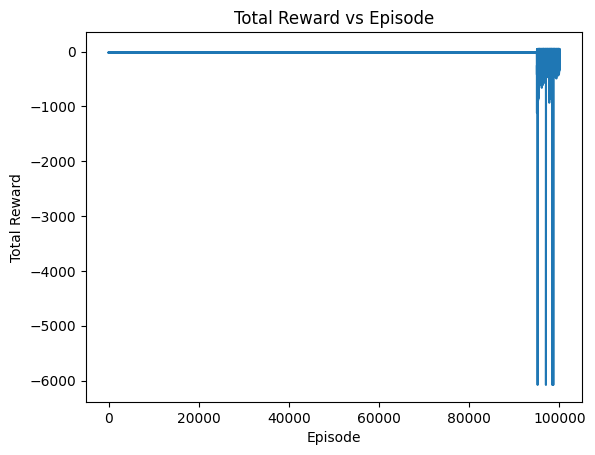

In [6]:
# plot the total reward
import matplotlib.pyplot as plt
plt.plot(lasy_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()

In [3]:
def simple_table_q_learning(
    episode=5000, alpha=0.1, gamma=0.99,
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, memory=10000
):
    q_table = {}
    total_rewards = []
    total_steps = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment
        fuel_limit = 1
        env = SimpleTaxiEnv(fuel_limit=fuel_limit)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        saved = False
        if (i + 1) % memory == 0:
            saved = True
            print(f"=========================={i+1}th episodes Start!==========================")

        # Unpack environment state
        (
            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        ) = raw_state

        state = (
            obstacle_south, obstacle_north, obstacle_east, obstacle_west
        )

        # Q-learning loop
        while not done:
            # Initialize Q-values for unseen state
            if state not in q_table:
                q_table[state] = np.zeros(6)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])

            # Take action in environment
            next_raw_state, reward, done, _ = env.step(action)

            step_count += 1

            # if saved:
            #     env.render_env(taxi_pos, action = action, step = step_count)

            # Unpack next state
            (
                taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
                obstacle_north, obstacle_south, obstacle_east, obstacle_west,
                passenger_look, destination_look
            ) = next_raw_state

            next_state = (
                obstacle_south, obstacle_north, obstacle_east, obstacle_west
            )

            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward shaping (distance to goal)
            # shaped_reward -= 1 * (abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]))
            total_reward += reward

            if saved:
                print(f"Shaped_Reward: {reward}, Reward: {reward}")

            # Q-learning update
            q_table[state][action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)

        # Optional progress logging
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return q_table, total_rewards


def save_q_table(q_table, filename='q_table.pkl'):
    """Save the Q-table to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

In [9]:
simple_q_table, simple_reward = simple_table_q_learning(episode = 300000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.001, epsilon_decay = 0.9999, memory = 10000000)
save_q_table(simple_q_table, filename='simple_q_table.pkl')

  5%|▍         | 13827/300000 [00:00<00:13, 21166.51it/s]

Episode: 10000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.3679


  8%|▊         | 22879/300000 [00:01<00:12, 22096.57it/s]

Episode: 20000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.1353


 11%|█▏        | 34277/300000 [00:01<00:12, 22037.90it/s]

Episode: 30000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0498


 15%|█▌        | 45295/300000 [00:02<00:11, 21270.99it/s]

Episode: 40000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0183


 18%|█▊        | 54334/300000 [00:02<00:10, 22339.20it/s]

Episode: 50000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0067


 21%|██▏       | 63997/300000 [00:02<00:11, 20646.99it/s]

Episode: 60000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0025


 24%|██▍       | 73275/300000 [00:03<00:10, 21266.21it/s]

Episode: 70000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 27%|██▋       | 82226/300000 [00:03<00:10, 21668.37it/s]

Episode: 80000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 31%|███▏      | 93774/300000 [00:04<00:09, 21372.90it/s]

Episode: 90000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 35%|███▌      | 105249/300000 [00:04<00:08, 21741.99it/s]

Episode: 100000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 38%|███▊      | 113909/300000 [00:05<00:08, 21022.66it/s]

Episode: 110000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 41%|████      | 122583/300000 [00:05<00:08, 20850.84it/s]

Episode: 120000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 45%|████▍     | 134564/300000 [00:06<00:07, 22780.60it/s]

Episode: 130000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 48%|████▊     | 144114/300000 [00:06<00:07, 21878.33it/s]

Episode: 140000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 51%|█████▏    | 153776/300000 [00:07<00:06, 23011.66it/s]

Episode: 150000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 55%|█████▍    | 163859/300000 [00:07<00:05, 23396.51it/s]

Episode: 160000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 58%|█████▊    | 173255/300000 [00:07<00:05, 22660.94it/s]

Episode: 170000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 61%|██████    | 182612/300000 [00:08<00:05, 22080.05it/s]

Episode: 180000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 65%|██████▍   | 194551/300000 [00:08<00:04, 23027.54it/s]

Episode: 190000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 68%|██████▊   | 204446/300000 [00:09<00:04, 23041.70it/s]

Episode: 200000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 71%|███████   | 213746/300000 [00:09<00:04, 21421.89it/s]

Episode: 210000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 75%|███████▍  | 223634/300000 [00:10<00:03, 22811.81it/s]

Episode: 220000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 78%|███████▊  | 233044/300000 [00:10<00:02, 23206.75it/s]

Episode: 230000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 81%|████████  | 242815/300000 [00:11<00:02, 22620.40it/s]

Episode: 240000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 85%|████████▌ | 255037/300000 [00:11<00:01, 23178.84it/s]

Episode: 250000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 88%|████████▊ | 262658/300000 [00:11<00:01, 22875.96it/s]

Episode: 260000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 91%|█████████ | 272552/300000 [00:12<00:01, 23572.84it/s]

Episode: 270000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 94%|█████████▍| 283207/300000 [00:12<00:00, 23788.75it/s]

Episode: 280000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


 98%|█████████▊| 293457/300000 [00:13<00:00, 23705.59it/s]

Episode: 290000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


100%|██████████| 300000/300000 [00:13<00:00, 22094.41it/s]

Episode: 300000/300000, Total Reward: -0.1, Steps: 1, Epsilon: 0.0010


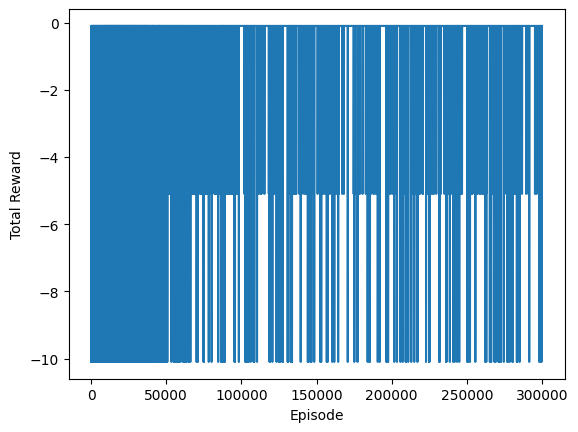

In [10]:
# plot the reward
import matplotlib.pyplot as plt
plt.plot(simple_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [11]:
print(simple_q_table)

{(0, 0, 0, 0): array([ -9.99974856,  -9.99974856,  -9.99974832,  -9.99974856,
       -19.12815153, -19.54659882]), (0, 1, 1, 0): array([ -9.99974232, -11.22592471, -11.42664907,  -9.99974301,
       -13.33671502, -15.28737679]), (0, 0, 0, 1): array([ -9.99974587,  -9.9997457 ,  -9.99974568, -12.66964915,
       -16.91689118, -17.40403028]), (0, 0, 1, 1): array([ -9.9997378 ,  -9.99973772, -10.17449426, -10.57589095,
       -12.9823273 , -13.53027668]), (0, 1, 0, 0): array([ -9.9997458 , -12.99038152,  -9.99974552,  -9.99974572,
       -17.58289409, -16.6100389 ]), (1, 1, 0, 0): array([-10.84457395, -10.55605307,  -9.99973902,  -9.99973942,
       -11.96019149, -13.66627498]), (1, 0, 0, 0): array([-11.68429049,  -9.99974581,  -9.99974563,  -9.99974465,
       -17.22355711, -17.78428703]), (1, 0, 1, 0): array([-11.08434805,  -9.99974249, -10.86398074,  -9.99974192,
       -16.42356081, -16.14875085]), (1, 0, 0, 1): array([-10.31805459,  -9.9997432 ,  -9.99974307, -11.03672584,
       -15